# Experiment 1. UNet (L)

The UNet ([Ronneberger et al., 2015](https://arxiv.org/abs/1505.04597) learns mapping between high-frequency data (> 4 Hz) and low-frequency data (< 5 Hz) directly. "L" in the title indicates that the target data is low-frequency data only.

The script trains 10 identical models initialized from different random seeds.

------
This notebook reproduces the workflow for an experiment from 
**"Multi-task learning for low-frequency extrapolation and elastic model building from seismic data"**

by [Ovcharenko Oleg](https://ovcharenkoo.com/), [Vladimir Kazei](https://vkazei.com/), [Tariq Alkhalifah](https://sites.google.com/a/kaust.edu.sa/tariq/home) and [Daniel Peter](https://github.com/danielpeter), KAUST, Saudi Arabia, 2021

In [1]:
# Most imports are in the shared_data_loading.ipynb
import os

# This is to prevent the error "this loop already running when doing magical %run <<notebook name>>"
import nest_asyncio
nest_asyncio.apply()

In [2]:
# Constrain visibility of GPUs by selected one. This is to enable training of multiple networks each on its own device
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# Where to save the trained model
root_pretrained = os.path.join('./pretrained_files/trained_nets/ex1_unet_l/')
root_out = os.path.join('./pretrained_files/trained_nets/ex1_unet_l/')

## Load data

1.8.1+cu102
3.8.3 (default, Oct 11 2020, 17:10:44) 
[GCC 7.5.0]
/home/ovcharoo/work/env_torch
{'high': {'flo': 4, 'btype': 'high', 'order': 8}, 'low': {'fhi': 5, 'btype': 'low', 'order': 8}, 'ulow': {'fhi': 2.5, 'btype': 'low', 'order': 8}}


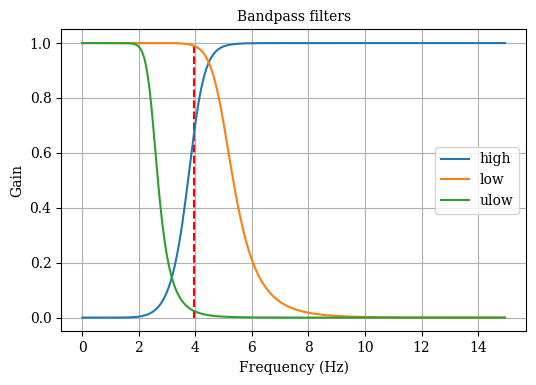

Not found! ./pretrained_files/data/syn_1024_el/cube_src_tr_h.npy
(64, 324, 3100)
Found 2765 files in ./pretrained_files/data/syn_1024_el/train/raw/:
	./pretrained_files/data/syn_1024_el/train/raw/model_0_seis_p.shot1.hh
	./pretrained_files/data/syn_1024_el/train/raw/model_1023_seis_p.shot3.hh
Load model cube from ./pretrained_files/data/syn_1024_el/rand_models.npy, (1024, 152, 500)
	max:	1.0
	min:	-1.0
(2765, 324, 3100) (2765, 324, 376)
Found 154 files in ./pretrained_files/data/syn_1024_el/val/raw/:
	./pretrained_files/data/syn_1024_el/val/raw/model_0_seis_p.shot2.hh
	./pretrained_files/data/syn_1024_el/val/raw/model_1017_seis_p.shot3.hh
(154, 324, 3100) (154, 324, 376)
Start split for (64, 324, 3100)
Start making cubes from lists for list 64, where each sublist 3
(64, 324, 376)
(64, 324, 376)
(64, 324, 376)
Start split for (2765, 324, 3100)
Start making cubes from lists for list 2765, where each sublist 3
(2765, 324, 376)
(2765, 324, 376)
(2765, 324, 376)
Start split for (154, 324, 3

In [ ]:
%run shared_data_loading.ipynb

# UNet

In [ ]:
from utils.archs import UNet_ext
summary(UNet_ext(1, 1).to(0), (1, 324, 376))

# Define training

https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example-pytorch.ipynb

https://pytorch.org/docs/stable/notes/amp_examples.html

https://paperswithcode.com/paper/multi-task-learning-using-uncertainty-to#code

https://towardsdatascience.com/self-paced-multitask-learning-76c26e9532d0

In [ ]:
def plot_metrics(m, title=''):
    fig, ax = plt.subplots(1, 1)
    axis = [ax, ax.twinx()]
    colors = ['r', 'b', 'm', 'c', 'g', 'navy']
    for phase, loss_dict in m.items():
        color_phase = '--' if phase == 'val' else ''
        for i, (ln, val) in enumerate(loss_dict.items()):
            if 'w' in ln and phase == 'train':
                this_ax = axis[1]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            elif not 'w' in ln:
                this_ax = axis[0]
                this_ax.plot(val, colors[i] + color_phase, label=f'{ln}_{phase}')
            
    axis[0].legend(loc='upper right')
    axis[1].legend(loc='lower right')
    plt.title(title)
    plt.show()

    
class LFNet(backbone.BaseModel):
    def __init__(self, ae, opt, imodel):
        super().__init__()
        self.net_g = UNet_ext(1, 1)
        backbone.init_weights(self.net_g, 'xavier')
            
        self.opt = opt
        self.load_dir = opt['load_pretrained']
        self.save_dir = opt['save_dir']
        self.epochs = opt['epochs']
        self.imodel = imodel

        self.model_names = ['_g']
        self.phases = ['train', 'val']
        self.running_metrics_g = {}
        self.running_metrics_lr = {'train': {'lr': []}}
        for p in self.phases:
            self.running_metrics_g[p] = {'data': [], 'model': []}
        
        if self.load_dir:
            self.load_networks(self.load_dir, 0)
            self.load_history(self.load_dir)
            self.load_lr_history(self.load_dir)
            
        self.loss_pix = nn.L1Loss()
        
        self.gpu_ids = [i for i in range(torch.cuda.device_count())]
        self.device = opt['device'] if opt['device'] else min(self.gpu_ids)
        
        self.net_g = self.net_g.to(self.device)
        self.scaler = None
        
        if len(self.gpu_ids) > 1:
            print(f'DataParallel on {self.gpu_ids}')
            self.net_g = torch.nn.DataParallel(self.net_g, device_ids=self.gpu_ids)
            params_g = list(self.net_g.module.parameters())
        else:
            params_g = list(self.net_g.parameters())
            
        self.optimizer_g = torch.optim.Adam(params_g, 
                                            lr=opt['lr_min'], betas=(0.5, 0.9), weight_decay=1e-5)
        
        # Scheduler curves
        # https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
        # https://pytorch.org/docs/master/generated/torch.optim.lr_scheduler.OneCycleLR.html#torch.optim.lr_scheduler.OneCycleLR
        self.scheduler = torch.optim.lr_scheduler.OneCycleLR(self.optimizer_g, 
                                                        max_lr=opt['lr_max'],
                                                        cycle_momentum=False,
                                                        epochs=self.epochs,
                                                        steps_per_epoch=opt['len_loader'])
    def train_batch(self, data, phase):
        hs = data[0].to(self.device)
        ls = data[1].to(self.device)

        with torch.set_grad_enabled(phase != 'val'):
            with autocast():
                lusp = self.net_g(hs)
                loss_data = self.loss_pix(lusp, ls.detach())
                loss_g = loss_data.sum()

            if phase == "train":
                self.optimizer_g.zero_grad()
                self.scaler.scale(loss_g).backward()
                self.scaler.step(self.optimizer_g)
                self.scaler.update()
                self.scheduler.step()
        return loss_g
                            
            
    def train(self, dtrain, dval):
        os.makedirs(self.save_dir, exist_ok=True)
        t1 = time.time()
        
        self.scaler = torch.cuda.amp.GradScaler()
        
        for iepoch in range(self.epochs):
            clear_output()
            plot_metrics(self.running_metrics_g, title=f'Generator. Epoch {iepoch} / {self.epochs}')
            plot_metrics(self.running_metrics_lr, title=f'Learning Rate. Epoch {iepoch} / {self.epochs}')                                                 
            print(f'{iepoch+1}/{self.epochs} ...')
                                                             
            # Remember learning rate
            print(self.imodel, self.optimizer_g.param_groups[0]["lr"])
            self.running_metrics_lr[self.phases[0]]['lr'].append(self.optimizer_g.param_groups[0]["lr"])            
            
            for phase in self.phases:
                print(phase)
                if phase=='train':
                    data_loader = dtrain
                else:
                    data_loader = dval
                
                prog_bar = tqdm.auto.tqdm(data_loader)
                for i, data in enumerate(prog_bar):
                    loss_g = self.train_batch(data, phase)

                self.running_metrics_g[phase]['data'].append(loss_g.sum().item())

            if iepoch == 0 or (iepoch - 1) % 5 == 0:
                print(f'Save state at epoch {iepoch}')
                self.save_networks(0)
                self.save_history(self.save_dir)
                self.save_lr_history(self.save_dir)

    def from_numpy(self, x):
        if len(x.shape) == 3:
            x = np.expand_dims(x, 0)
        return torch.from_numpy(x).type(torch.FloatTensor).to(self.device)

    def predict(self, h):
        if isinstance(h, np.ndarray):
            h = self.from_numpy(h)
        lup = self.net_g(h)
        lp = lup[:, 0:1, ...]
        return sd.dcn(lp), sd.dcn(lp), sd.dcn(lp)

## Train an ensemble of networks
Uncomment cells below to init batch loaders and **train network from scratch**

In [ ]:
opt= {'batch_size': 4,
      'epochs': 81,
      'lr_min': 1e-5,
      'lr_max': 1e-3,
      'load_pretrained': '',
      'save_dir': root_out,
      'device': 0,
      'scheduler': True}

dataset_train = torch.utils.data.DataLoader(jjloader_tr, 
                                            batch_size=opt['batch_size'], 
                                            shuffle=True, 
                                            num_workers=4, 
                                            drop_last=True, 
                                            pin_memory=True)
dataset_val = torch.utils.data.DataLoader(jjloader_te, 
                                          batch_size=opt['batch_size'], 
                                          shuffle=False, 
                                          num_workers=4, 
                                          drop_last=False, 
                                          pin_memory=True)

opt['len_loader'] = len(dataset_train)

In [ ]:
# for i in range(0, 10):
#     opt['save_dir'] = root_out[:-1] + f'_{i}'
# #     opt['load_pretrained'] = root_pretrained[:-1] + f'_{i}'
#     opt['load_pretrained'] = ''
#     net = LFNet(None, opt, i)
#     net.train(dataset_train, dataset_val)

## Load one pre-trained network

In [ ]:
opt['load_pretrained'] = root_pretrained[:-1] + f'_{0}'
net = LFNet(None, opt, i)

In [ ]:
plot_metrics(net.running_metrics_g, title='Generator')

Struction of data, d:
```0 - syn input
1 - syn low
2 - syn ulow
3 - velocity model
4 - field input
5 - field low
6 - filed ulow
7 - velocity model (zeros)```

In [ ]:
hs_true = d[0].copy()
print(hs_true.shape)
us_pred, ls_pred, ms_pred = net.predict(hs_true)
print(ls_pred.shape)
print(us_pred.shape)
print(ms_pred.shape)

In [ ]:
nt_clip=None
vlim_f = {'vmin': -0.25, 'vmax': 0.25}
vlim_2f = {'vmin': -0.125, 'vmax': 0.125}
fhp = 0.5
fedge = par['fedge']
dt_net = dt

ls_true = d[1].copy(); lst = ls_true[0,...]; ls = ls_pred[0,0,...]
vis.plot_shot(np.concatenate([lst, ls, lst - ls]), colorbar=False, **vlim_f,
              title=f'Syn < {_max_freq} Hz: true, pred, diff')